# Welcome to my Youtube Tranding videos analysis!
In this notebook I will try to understand whats patterns have US videos form trends or *how to be in trend?* <br>
Questions bellow I will answer while analysis:
<ul>
    <li>How important are missing data in videos?</li>
    <li>What the most fequent words use peoples?</li>
    <li>What distribution of likes, dislikes, reviews, comments?</li>
    <li>What the most popular categories of video?</li>
    <li>What the most liked, disliked, discussed and positive category?</li>
</ul>
P.S. It's my first analysis, so don't be so strict.

## Libraries and main functions

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

import json
from collections import Counter
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [30]:
def ids_to_category(id, word_list):
    return word_list[id]

def plot_distribution(data, distc, target):
    facet = sns.FacetGrid(data, hue=target, aspect=3, height=5, palette="ch:.25")
    facet.map(sns.distplot, distc)
    facet.add_legend()
    plt.show()
    
def binary_pie_plot(data, labels, column, title=''):
    sizes = np.zeros((len(labels),))
    sizes[0] = (data[column][data[column] == True].shape[0]*100)/data[column].shape[0]
    sizes[1] = (data[column][data[column] == False].shape[0]*100)/data[column].shape[0]
    
    fig1, ax1 = plt.subplots(figsize=(10, 10))
    wedges, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.1f%%', textprops=dict(color="w"),
                                    colors=['#D3BBAC', '#76485F'], startangle=90)
    ax1.legend(wedges, labels,
          title=column,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=20, weight="bold")
    ax1.set_title(title, fontdict=dict(fontsize=30))
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
    
def datetime_time(x):
    return x.split('T')[0]

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%y.%d.%m")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

## Data description

In [3]:
videos = pd.read_csv('USvideos.csv')
videos.drop_duplicates(inplace=True)
videos.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [4]:
videos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40901 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  40901 non-null object
trending_date             40901 non-null object
title                     40901 non-null object
channel_title             40901 non-null object
category_id               40901 non-null int64
publish_time              40901 non-null object
tags                      40901 non-null object
views                     40901 non-null int64
likes                     40901 non-null int64
dislikes                  40901 non-null int64
comment_count             40901 non-null int64
thumbnail_link            40901 non-null object
comments_disabled         40901 non-null bool
ratings_disabled          40901 non-null bool
video_error_or_removed    40901 non-null bool
description               40332 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.5+ MB


## Little data processing

In [5]:
json_file = None
with open('US_category_id.json') as f:
    json_file = json.loads(f.read())

In [6]:
word_list = {}
for i in range(len(json_file['items'])):
    word_list[int(json_file['items'][i]['id'])] = json_file['items'][i]['snippet']['title']

In [7]:
videos['category_id'] = videos['category_id'].apply(lambda x: ids_to_category(x, word_list))

In [8]:
videos['publish_time'] = videos['publish_time'].apply(lambda x: datetime_time(x))

## NaN values
The first going to look at missing values. Why is it important? So, lack of some content is can be one of resons not to find video in either trends or recommendations.

In [9]:
videos.isnull().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               569
dtype: int64

As we can see only *description* have **NaN** values, but its not true. Lets look at *tags*.

In [10]:
videos['tags'][videos['tags'] == '[none]'].shape[0]

1534

Well, instead of **NaN** values in column *tags* there analog — **[none]** values presented as a *string*. There about *1535* **NaN** values in *tags* column. Let's convert it to real **NaN** values for our comfort.

In [11]:
videos['tags'][videos['tags'] == '[none]'] = None

In [12]:
videos.isnull().sum()

video_id                     0
trending_date                0
title                        0
channel_title                0
category_id                  0
publish_time                 0
tags                      1534
views                        0
likes                        0
dislikes                     0
comment_count                0
thumbnail_link               0
comments_disabled            0
ratings_disabled             0
video_error_or_removed       0
description                569
dtype: int64

All **NaN-like** values was filled by real **NaN** values. Let's look at distribution of *views, likes, comment_count* and *dislikes* columns in depends on **NaN** and **not-NaN** values of *description* and *tags* columns to define is it important to have tags or description to be in trend. Before plotting let's normalize all data via *log* and change values of *tags* and *description* to **NaN** or **Not-NaN** strings.

In [13]:
df_plot = videos[['likes', 'views', 'dislikes', 'comment_count', 'tags', 'description']].copy()

# np.log(x + 1)
df_plot['likes'] = (df_plot['likes'] + 1).transform(np.log)
df_plot['views'] = (df_plot['views'] + 1).transform(np.log)
df_plot['dislikes'] = (df_plot['dislikes'] + 1).transform(np.log)
df_plot['comment_count'] = (df_plot['comment_count'] + 1).transform(np.log)

df_plot = df_plot.fillna('NaN')
df_plot['tags'][df_plot['tags'] != 'NaN'] = 'Not-NaN'
df_plot['description'][df_plot['description'] != 'NaN'] = 'Not-NaN'

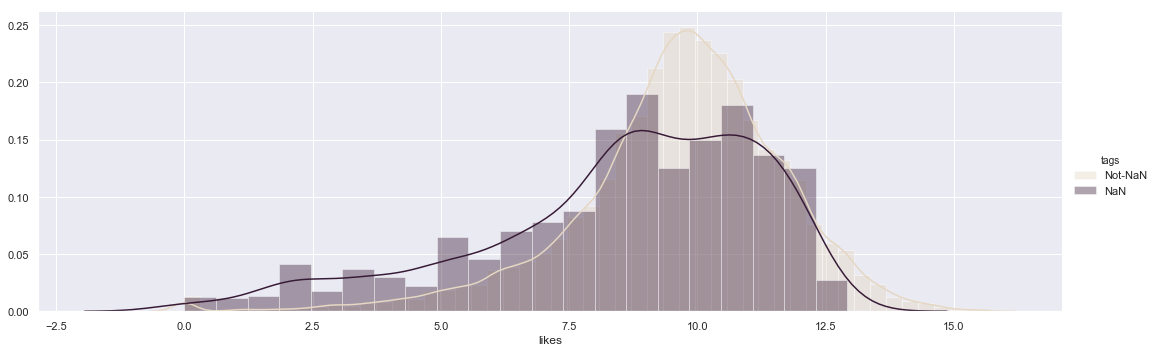

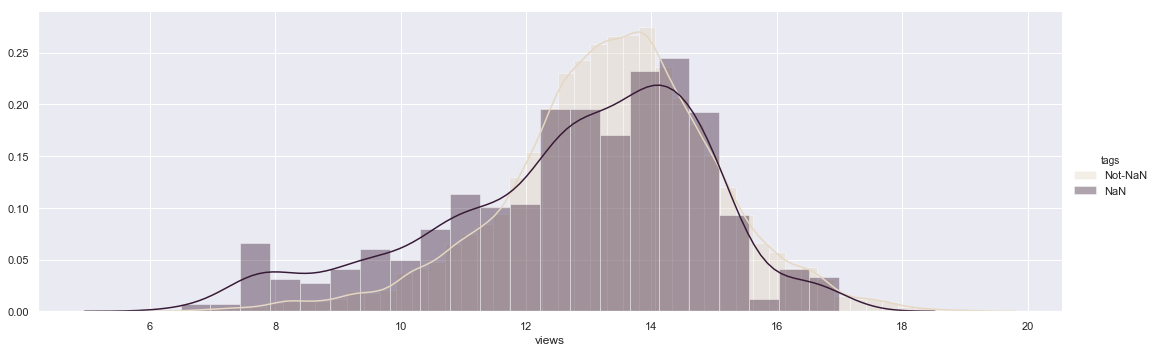

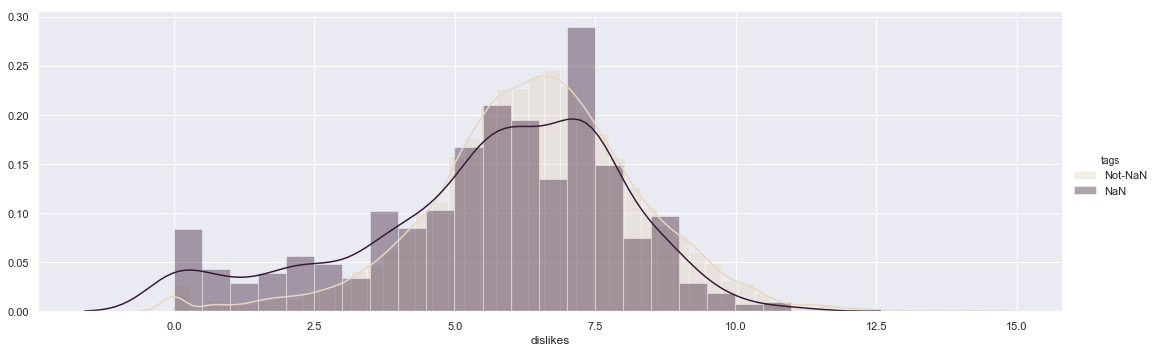

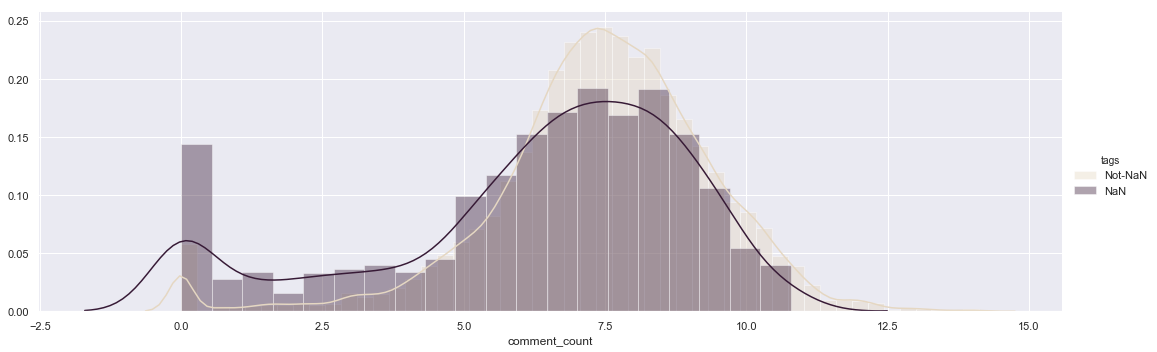

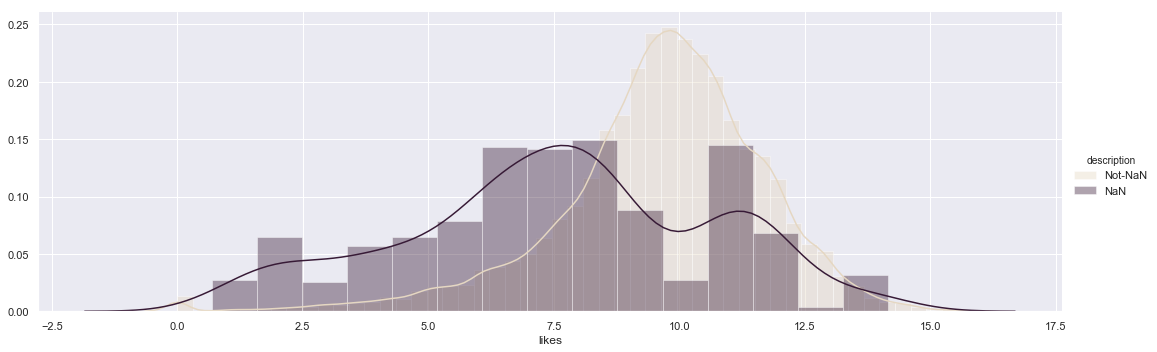

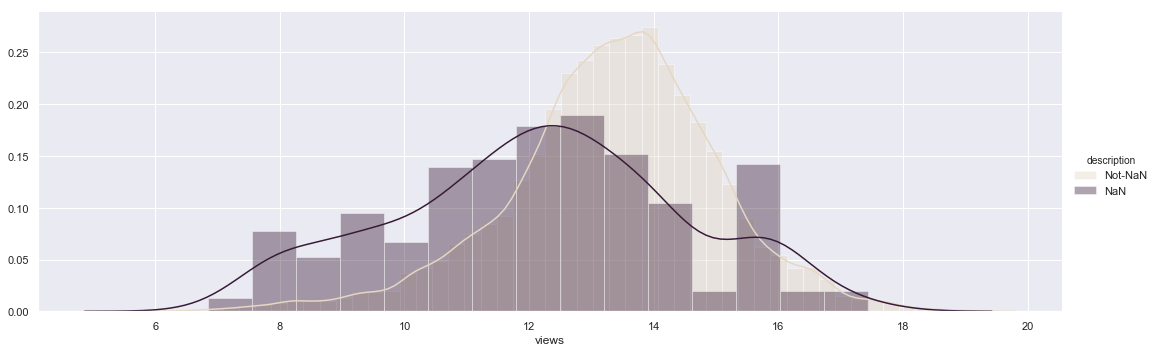

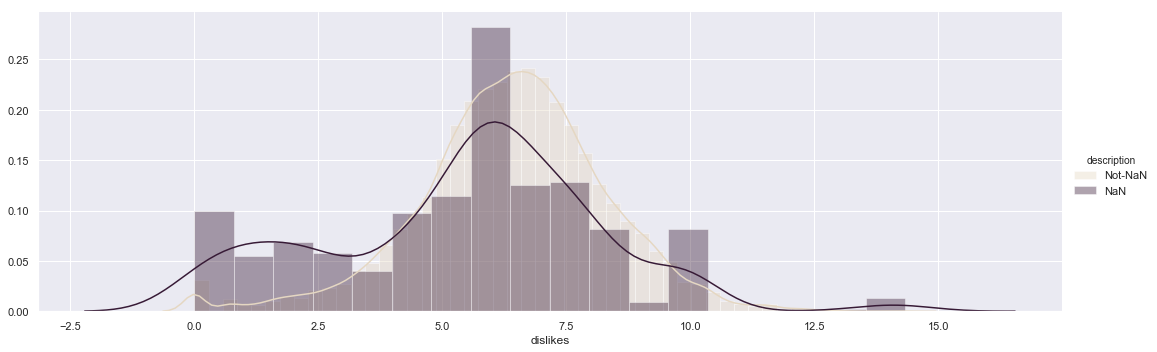

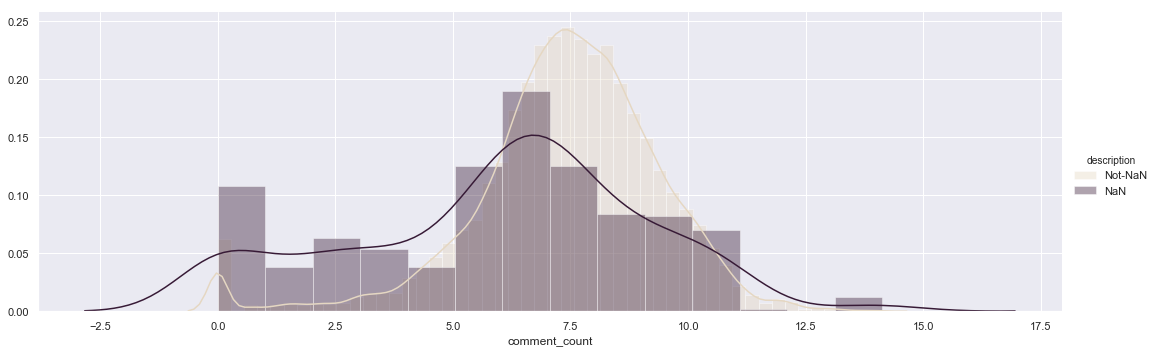

In [14]:
for i in ['tags', 'description']:
    for j in ['likes', 'views', 'dislikes', 'comment_count']:
        plot_distribution(df_plot, j, i)

So, all **NaN** values are a little bit offset left in distribution it means that all indicators (views, likes, dislikes, comment count) decrease in compare with **Not-NaN** values. The most different distributions are *views* distributions that depends on *description*. Let's look whats more important: *description* or *tags*.

#### Likes average

In [15]:
avg_nan = df_plot['likes'][df_plot['tags'] == 'NaN'].mean()
avg_not_nan = df_plot['likes'][df_plot['tags'] == 'Not-NaN'].mean()

print('Difference between two avg by tags:', avg_nan - avg_not_nan)

avg_nan = df_plot['likes'][df_plot['description'] == 'NaN'].mean()
avg_not_nan = df_plot['likes'][df_plot['description'] == 'Not-NaN'].mean()

print('Difference between two avg by description:', avg_nan - avg_not_nan)

Difference between two avg by tags: -1.1089584380589166
Difference between two avg by description: -2.054519825571262


#### Dislikes average

In [16]:
avg_nan = df_plot['dislikes'][df_plot['tags'] == 'NaN'].mean()
avg_not_nan = df_plot['dislikes'][df_plot['tags'] == 'Not-NaN'].mean()

print('Difference between two avg by tags:', avg_nan - avg_not_nan)

avg_nan = df_plot['dislikes'][df_plot['description'] == 'NaN'].mean()
avg_not_nan = df_plot['dislikes'][df_plot['description'] == 'Not-NaN'].mean()

print('Difference between two avg by description:', avg_nan - avg_not_nan)

Difference between two avg by tags: -0.7793763794848916
Difference between two avg by description: -0.9579849364948823


#### Views average

In [17]:
avg_nan = df_plot['views'][df_plot['tags'] == 'NaN'].mean()
avg_not_nan = df_plot['views'][df_plot['tags'] == 'Not-NaN'].mean()

print('Difference between two avg by tags:', avg_nan - avg_not_nan)

avg_nan = df_plot['views'][df_plot['description'] == 'NaN'].mean()
avg_not_nan = df_plot['views'][df_plot['description'] == 'Not-NaN'].mean()

print('Difference between two avg by description:', avg_nan - avg_not_nan)

Difference between two avg by tags: -0.6136751153672488
Difference between two avg by description: -1.1786658840617399


#### Comment count average

In [18]:
avg_nan = df_plot['comment_count'][df_plot['tags'] == 'NaN'].mean()
avg_not_nan = df_plot['comment_count'][df_plot['tags'] == 'Not-NaN'].mean()

print('Difference between two avg by tags:', avg_nan - avg_not_nan)

avg_nan = df_plot['comment_count'][df_plot['description'] == 'NaN'].mean()
avg_not_nan = df_plot['comment_count'][df_plot['description'] == 'Not-NaN'].mean()

print('Difference between two avg by description:', avg_nan - avg_not_nan)

Difference between two avg by tags: -1.1275278266461193
Difference between two avg by description: -1.4552704786152475


Following values above I can confirm my hypopthesis that videos with **NaN** values gets less *likes, dislikes, views* and *comments*. So, depends on difference betwen averages I can say that lack of description is much more important than lack of tags.

## Comment and rating ability
The second we have to get know: is it important to haven't disabled comments or ratings?

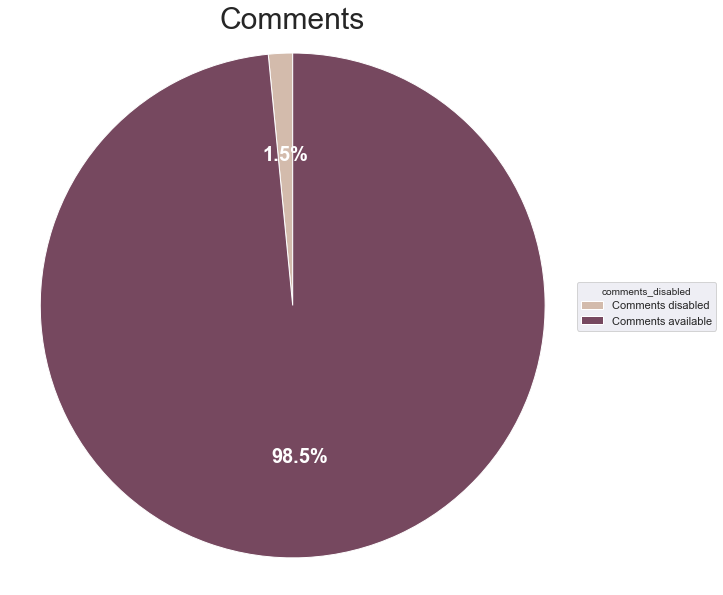

In [19]:
binary_pie_plot(videos, ['Comments disabled', 'Comments available'], 'comments_disabled', 'Comments')

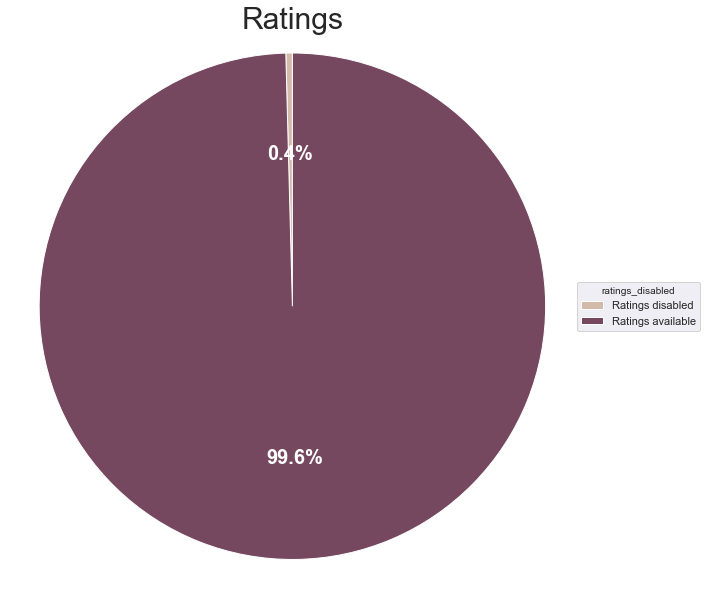

In [20]:
binary_pie_plot(videos, ['Ratings disabled', 'Ratings available'], 'ratings_disabled', 'Ratings')

After plotting rating importance and comments importance we can notice that only the least number of videos haven't ability to comment or rate them, therefore more trending videos have ability to give feedback to authors.

## The most popular categories

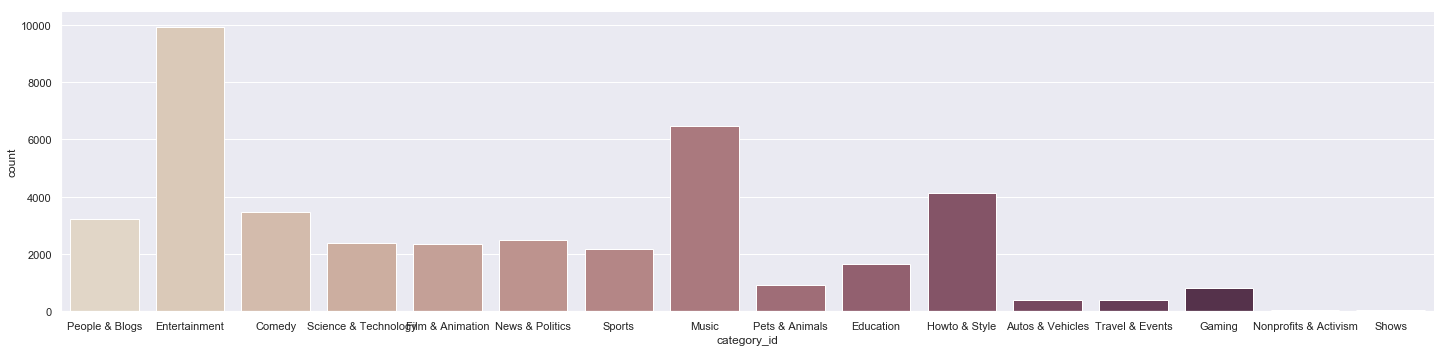

In [21]:
sns.catplot(x="category_id", kind="count", palette="ch:.25", data=videos, height=5, aspect=4);
plt.show()

Following the plot above we can notice that the most trending category is an Entertainment. Let's look at top 5 categories.

In [22]:
for j, i in enumerate(Counter(videos['category_id']).most_common(10)):
    print(str(j+1)+'.'+i[0]+':', i[1])
top_categories = [i[0] for i in Counter(videos['category_id']).most_common(10)]

1.Entertainment: 9944
2.Music: 6467
3.Howto & Style: 4142
4.Comedy: 3453
5.People & Blogs: 3208
6.News & Politics: 2485
7.Science & Technology: 2397
8.Film & Animation: 2343
9.Sports: 2172
10.Education: 1655


After we got know top 10 categories, so, we can find the most liked, disliked, positive, discussed and viewed categories from top 10 categories we define before.

In [23]:
liked = []
disliked = []
viewed = []
liked_disliked = []
discussed = []

for i in top_categories:
    
    viewed.append((i, int(videos['views'][videos['category_id'] == i].mean())))
    disliked.append((i, int(videos['dislikes'][videos['category_id'] == i].mean())/viewed[-1][1]))
    liked.append((i, int(videos['likes'][videos['category_id'] == i].mean())/viewed[-1][1]))
    discussed.append((i, int(videos['comment_count'][videos['category_id'] == i].mean())/viewed[-1][1]))
    liked_disliked.append((i, liked[-1][1]/disliked[-1][1]))
    
liked.sort(key=lambda x: x[1], reverse=True)
disliked.sort(key=lambda x: x[1], reverse=True)
viewed.sort(key=lambda x: x[1], reverse=True)
liked_disliked.sort(key=lambda x: x[1], reverse=True)
discussed.sort(key=lambda x: x[1], reverse=True)

#### Liked

In [24]:
print('The most liked categories (likes per view):')
print('-------------------------------------------')
for j, i in enumerate(liked):
    print(str(j+1)+'. '+i[0] + ':', str(i[1])+' likes/views')

The most liked categories (likes per view):
-------------------------------------------
1. Comedy: 0.04228573899214924 likes/views
2. Education: 0.04172924581087847 likes/views
3. Howto & Style: 0.03992019217366444 likes/views
4. People & Blogs: 0.037953023422952537 likes/views
5. Music: 0.035302805451800354 likes/views
6. Entertainment: 0.025739364091988688 likes/views
7. Science & Technology: 0.023680427745194042 likes/views
8. Film & Animation: 0.02278590948758461 likes/views
9. Sports: 0.02239572388768694 likes/views
10. News & Politics: 0.012311232270341031 likes/views


#### Disliked

In [25]:
print('The most disliked categories (dislikes per view):')
print('-------------------------------------------------')
for j, i in enumerate(disliked):
    print(str(j+1)+'. '+i[0] + ':', str(i[1])+' dislikes/views')

The most disliked categories (dislikes per view):
-------------------------------------------------
1. News & Politics: 0.0028357332757527093 dislikes/views
2. Entertainment: 0.002086387266170106 dislikes/views
3. People & Blogs: 0.0020724576132762733 dislikes/views
4. Comedy: 0.0014119341538765024 dislikes/views
5. Howto & Style: 0.0013409831095139598 dislikes/views
6. Science & Technology: 0.0013042695159089827 dislikes/views
7. Music: 0.0012751467579168046 dislikes/views
8. Sports: 0.0011656115489759094 dislikes/views
9. Education: 0.001144304351301436 dislikes/views
10. Film & Animation: 0.0008352899191048632 dislikes/views


#### Viewed

In [26]:
print('The most average viewed categories:')
print('-----------------------------------')
for j, i in enumerate(viewed):
    print(str(j+1)+'. '+i[0] + ':', str(i[1])+' views')

The most average viewed categories:
-----------------------------------
1. Music: 6204776 views
2. Film & Animation: 3101917 views
3. Entertainment: 2067689 views
4. Sports: 2027262 views
5. People & Blogs: 1530550 views
6. Comedy: 1480239 views
7. Science & Technology: 1449087 views
8. Howto & Style: 982861 views
9. Education: 713097 views
10. News & Politics: 592792 views


#### Likes / dislikes

In [27]:
print('The most positive categories (likes/dislikes):')
print('----------------------------------------------')
for j, i in enumerate(liked_disliked):
    print(str(j+1)+'. '+i[0] + ':', str(i[1]))

The most positive categories (likes/dislikes):
----------------------------------------------
1. Education: 36.466911764705884
2. Comedy: 29.948803827751195
3. Howto & Style: 29.769347496206375
4. Music: 27.685288169868556
5. Film & Animation: 27.279042840602084
6. Sports: 19.21371138383411
7. People & Blogs: 18.313051702395967
8. Science & Technology: 18.156084656084655
9. Entertainment: 12.336810384793695
10. News & Politics: 4.341463414634147


#### Discussed

In [28]:
print('The most discussed categories (comments/views):')
print('-----------------------------------------------')
for j, i in enumerate(discussed):
    print(str(j+1)+'. '+i[0] + ':', str(i[1]) + ' comments/views')

The most discussed categories (comments/views):
-----------------------------------------------
1. Howto & Style: 0.0056722161119425836 comments/views
2. People & Blogs: 0.005041978373787201 comments/views
3. Education: 0.004609471081774289 comments/views
4. Comedy: 0.004401316273926035 comments/views
5. News & Politics: 0.004097558671507038 comments/views
6. Entertainment: 0.003572103928588874 comments/views
7. Science & Technology: 0.0034414772888032258 comments/views
8. Music: 0.003121949930182814 comments/views
9. Sports: 0.0025408654628755437 comments/views
10. Film & Animation: 0.0024597692330259 comments/views


So, following the data above *Education* has one of the bests indicators in *likes*, *likes/dislikes* and *dislikes*, but with not a big number of views. The top 3 the most discussed categories are *Howto & Style*, *People & Blogs* and *Education*. By the statistics peoples don't love *News & Politics* in compare with other categories. And the most viewed categories are *Music*, *Film & Animation* and *Entertainment* exactly. After looked at main indicators, let's try to understand what the fastest category in propagation.

In [34]:
tmp = []
for i in range(videos.shape[0]):
    tmp.append(days_between(videos['trending_date'].iloc[i], videos['publish_time'].iloc[i]))
videos['days_to_trend'] = tmp

In [43]:
trended = []
for i in set(videos['category_id']):
    trended.append((i, int(videos['days_to_trend'][videos['category_id'] == i].mean())))
trended.sort(key=lambda x: x[1], reverse=False)

In [48]:
print('Average count of days to trend for each category:')
print('-------------------------------------------------')
for j, i in enumerate(trended):
    print(str(j+1)+'. '+i[0] + ':', str(i[1]) + ' days')

Average count of days to trend for each category:
-------------------------------------------------
1. Nonprofits & Activism: 5 days
2. Pets & Animals: 7 days
3. Travel & Events: 7 days
4. Howto & Style: 7 days
5. Comedy: 10 days
6. Shows: 10 days
7. Entertainment: 13 days
8. Music: 14 days
9. People & Blogs: 15 days
10. News & Politics: 18 days
11. Science & Technology: 18 days
12. Gaming: 21 days
13. Sports: 23 days
14. Education: 37 days
15. Film & Animation: 41 days
16. Autos & Vehicles: 43 days


Well, average the fastests categories are *Nonprofits & Activism*, *Pets & Animals*, *Travel & Events* and *Howto & Style*. What give us this data? So, as we can notice the most popular categories don't the most fastest it means that we can't chain this two meaning.

## The Title
Before this section we only was analysis video after click (factors that peoples usually don't see) let's analysis that people see firstly - the title.

In [70]:
stopWords = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
words = []
for i in range(videos['title'].shape[0]):
    for i in tokenizer.tokenize(videos['title'].iloc[i]):
        if not i in stopWords or len(i) > 2:
            words.append(i.lower())

In [71]:
c = Counter()
for word in words:
    c[word] += 1

In [76]:
c.most_common(20)

[('the', 10018),
 ('official', 3985),
 ('video', 2861),
 ('with', 2831),
 ('and', 2358),
 ('a', 2350),
 ('2018', 2292),
 ('i', 2257),
 ('trailer', 1998),
 ('to', 1961),
 ('you', 1888),
 ('how', 1862),
 ('my', 1845),
 ('for', 1788),
 ('ft', 1300),
 ('from', 1258),
 ('in', 1219),
 ('what', 1106),
 ('vs', 1044),
 ('is', 1035)]

Well, we see the most common words in titles. Now, let's look at how long titles in trends.

In [81]:
avg_len = 0
max_len = 0
min_len = 10000000000000000000000

for i in range(videos.shape[0]):
    tmp = len(videos['title'].iloc[i])
    avg_len += tmp
    
    if min_len > tmp:
        min_len = tmp
    elif max_len < tmp:
        max_len = tmp
avg_len = int(avg_len / videos.shape[0])

In [84]:
max_len

100

In [85]:
print('Maximum length of title:', max_len)
print('Minimum length of title:', min_len)
print('Average length of title:', avg_len)

Maximum length of title: 100
Minimum length of title: 3
Average length of title: 48


## Summary
After analysis we understood common patterns of US tranding videos in YouTube and answered questions above. <br>
There a little resume:
<ul>
    <li>missing data are not the most important things</li>
    <li>comment and rating ability is one of the most important factor in trends</li>
    <li>most popular categories are Enterntainment, Music and Howto & Style</li>
    <li>most liked categories are Comedy, Education and Howto & Style</li>
    <li>most disliked categories are New & Politics, Enterntainment and Peoples & Blogs</li>
    <li>most viewed categories are Music, Film & Animation and Enterntainment</li>
    <li>most discussed categories are Howto & Style and People & Blogs</li>
    <li>most positive categories are Education and Comedy</li>
    <li>most frequent words are 'the', 'official' and 'video'</li>
    <li>average title length is around 48</li>
</ul>